In [443]:
import numpy as np
import pandas as pd
import tushare as ts
from talib.abstract import *
import sklearn
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import statsmodels
import statsmodels.api as sm
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import math

from arch import arch_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import metrics

In [444]:
#import os
#os.chdir('/Users/xupech/Downloads/Final Project/Data')

In [532]:
sp5001 = pd.read_csv('./S&P_500.csv')

sp500 = sp5001.iloc[::-1].reset_index(drop=True)

sp500.index = sp500.Date
del sp500['Date']

sp500 = sp500.loc['12/29/2006':]

# Log of Close Price
sp500['plog'] = np.log(sp500.Close)

# Log of Volume
sp500['vlog'] = np.log(sp500.Volume)
sp500.tail()

,Open,High,Low,Close,Adj Close,Volume,plog,vlog
Date,,,,,,,,
1/6/2020,3217.550049,3246.840088,3214.639893,3246.280029,3246.280029,3674070000,8.085265,22.024566
1/7/2020,3241.860107,3244.909912,3232.429932,3237.179932,3237.179932,3420380000,8.082458,21.953017
1/8/2020,3238.590088,3267.070068,3236.669922,3253.050049,3253.050049,3720890000,8.087348,22.037229
1/9/2020,3266.030029,3275.580078,3263.669922,3274.699951,3274.699951,3638390000,8.093982,22.014807
1/10/2020,3281.810059,3282.989990,3260.860107,3265.350098,3265.350098,1631680402,8.091122,21.212876


In [446]:
# ret: Return.
sp500['lag_plog']=sp500.plog.shift(1)
sp500['ret']=sp500['plog']-sp500['lag_plog']

# rollstd: Rolling 14-day return standard deviation will be used as a feature to predict volatility. It takes clustering
# effect into consideration and will look back 14 days to compute standard deviation. Arbitrary number, worth 
# thinking over again.
sp500['rollstd']=sp500['ret'].rolling(14).std()

# voldiff: Volume difference, this will be used as input variable to predict volatility.
sp500['lag_vlog']=sp500.vlog.shift(1)
sp500['voldiff'] = sp500['vlog']-sp500['lag_vlog']


# Get rid of Nan values.
sp500 = sp500[14:]
sp500.head()

,Open,High,Low,Close,Adj Close,Volume,plog,vlog,lag_plog,ret,rollstd,lag_vlog,voldiff
Date,,,,,,,,,,,,,
1/23/2007,1422.949951,1431.329956,1421.660034,1427.989990,1427.989990,2975070000,7.264023,21.813533,7.260487,0.003536,0.003599,21.655477,0.158056
1/24/2007,1427.959961,1440.140015,1427.959961,1440.130005,1440.130005,2783180000,7.272489,21.746860,7.264023,0.008466,0.004137,21.813533,-0.066673
1/25/2007,1440.119995,1440.689941,1422.339966,1423.900024,1423.900024,2994330000,7.261155,21.819986,7.272489,-0.011334,0.005319,21.746860,0.073126
1/26/2007,1423.900024,1427.270020,1416.959961,1422.180054,1422.180054,2626620000,7.259946,21.688964,7.261155,-0.001209,0.005020,21.819986,-0.131023
1/29/2007,1422.030029,1426.939941,1418.459961,1420.619995,1420.619995,2730480000,7.258849,21.727743,7.259946,-0.001098,0.005017,21.688964,0.038780


In [447]:
# absret: Return in absolute form as a measure for volatility.
sp500['absret'] = abs(sp500['ret'])

print(np.mean(sp500['ret']))
# sqret: Mean of return small, assume data around zero and use squared return to denote volatility. Will need to take
# squared root in order to compare predicted results with real results later.
sp500['sqret'] = np.square(sp500['ret'])

0.0002543278743186029


In [448]:
# 0.7% as a threshold to determine if volatility is significant and entails more than noise, and thus price movement
# can be explained and forecasted using a price movement model.

# rollstd_07: determine if rollstd > 0.7%.
sp500['rollstd_07'] = sp500.rollstd>0.007
# absret_07: determine is absret > 0.7%.
sp500['absret_07'] = sp500.absret>0.007
sp500.head()

,Open,High,Low,Close,Adj Close,Volume,plog,vlog,lag_plog,ret,rollstd,lag_vlog,voldiff,absret,sqret,rollstd_07,absret_07
Date,,,,,,,,,,,,,,,,,
1/23/2007,1422.949951,1431.329956,1421.660034,1427.989990,1427.989990,2975070000,7.264023,21.813533,7.260487,0.003536,0.003599,21.655477,0.158056,0.003536,0.000013,False,False
1/24/2007,1427.959961,1440.140015,1427.959961,1440.130005,1440.130005,2783180000,7.272489,21.746860,7.264023,0.008466,0.004137,21.813533,-0.066673,0.008466,0.000072,False,True
1/25/2007,1440.119995,1440.689941,1422.339966,1423.900024,1423.900024,2994330000,7.261155,21.819986,7.272489,-0.011334,0.005319,21.746860,0.073126,0.011334,0.000128,False,True
1/26/2007,1423.900024,1427.270020,1416.959961,1422.180054,1422.180054,2626620000,7.259946,21.688964,7.261155,-0.001209,0.005020,21.819986,-0.131023,0.001209,0.000001,False,False
1/29/2007,1422.030029,1426.939941,1418.459961,1420.619995,1420.619995,2730480000,7.258849,21.727743,7.259946,-0.001098,0.005017,21.688964,0.038780,0.001098,0.000001,False,False


In [449]:
# Number of days when volatility greater than 0.7%, when a trading position will be forwarded.
print(len(sp500[sp500.absret>0.007]))

# Divided by number of trading days in the same period, sort of get the trading frequency.
print(1/(len(sp500[sp500.absret>0.007])/len(sp500)))

1222
2.6726677577741405


In [450]:
#Split train/test set.
trainset = sp500.loc[:'6/21/2018']
testset = sp500.loc['6/21/2018':]

# Length of train/test set.
ltrain = len(trainset)
ltest = len(testset)

#Proportion of trainset on total dataset.
print(len(testset)/len(sp500))

0.1200244947948561


In [533]:
ltest

392

In [451]:
# Helper Function.
# Variable rescaling function for model fitting.
def reshape(var):
    v_var = var.reshape(-1,1)
    v_var = v_var.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    # scaled variable.
    output = scaler.fit_transform(v_var)
    return output, scaler

# Create lookback variables， default lookback period = 1.
# Lookback on itself.
def create_dataset0(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)
# Lookback on an extra variable.
def create_dataset1(Xset, Yset,look_back=1):
    dataX, dataY = [], []
    for i in range(len(Xset) - look_back):
        a = Xset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(Yset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [452]:
# All variables that will be used in models.

# Dependent variables. Lags as X variables will created upon Y variables later.
absret = sp500.absret.values
# Scaled.
v_absret, scaler_absret = reshape(absret)

sqret =sp500.sqret.values
# Scaled.
v_sqret, scaler_sqret = reshape(sqret)

# Dummy variable.
absret_07 = sp500.absret_07.values
# Rescaled so that it can fit in create_dataset function.
v_absret07, scaler_absret07 =reshape(absret_07)
# Now datatype is float, ecessary to convert back to boolean?
v_absret07 = v_absret07.astype('bool_')

# Extra X variables.
rollstd = sp500.rollstd.values
# Scaled.
v_rollstd, scaler_rollstd = reshape(rollstd)

#Dummy variable.
rollstd_07 = sp500.rollstd_07.values
v_rollstd07, scaler_rollstd07 = reshape(rollstd_07)
v_rollstd07 = v_rollstd07.astype('bool_')

vlog = sp500.vlog.values
#Scaled.
v_vlog, scaler_vlog = reshape(vlog)

voldiff = sp500.voldiff.values
#Scaled.
v_voldiff, scaler_voldiff = reshape(voldiff)

rolldiff = sp500.absret.values - sp500.rollstd.values
# Scaled.
v_rolldiff, scaler_rolldiff = reshape(rolldiff)

sp500.head()

,Open,High,Low,Close,Adj Close,Volume,plog,vlog,lag_plog,ret,rollstd,lag_vlog,voldiff,absret,sqret,rollstd_07,absret_07
Date,,,,,,,,,,,,,,,,,
1/23/2007,1422.949951,1431.329956,1421.660034,1427.989990,1427.989990,2975070000,7.264023,21.813533,7.260487,0.003536,0.003599,21.655477,0.158056,0.003536,0.000013,False,False
1/24/2007,1427.959961,1440.140015,1427.959961,1440.130005,1440.130005,2783180000,7.272489,21.746860,7.264023,0.008466,0.004137,21.813533,-0.066673,0.008466,0.000072,False,True
1/25/2007,1440.119995,1440.689941,1422.339966,1423.900024,1423.900024,2994330000,7.261155,21.819986,7.272489,-0.011334,0.005319,21.746860,0.073126,0.011334,0.000128,False,True
1/26/2007,1423.900024,1427.270020,1416.959961,1422.180054,1422.180054,2626620000,7.259946,21.688964,7.261155,-0.001209,0.005020,21.819986,-0.131023,0.001209,0.000001,False,False
1/29/2007,1422.030029,1426.939941,1418.459961,1420.619995,1420.619995,2730480000,7.258849,21.727743,7.259946,-0.001098,0.005017,21.688964,0.038780,0.001098,0.000001,False,False


# 1. First Model.

In [453]:
# absret prediction using 14-day lags.
x,y=create_dataset0(v_absret, look_back=14)

# Split by train/test split defined above. Length - 14 b/c look_back period will start y from 15th.
xtrain, xtest = x[:ltrain-14], x[ltrain-14:]
ytrain, ytest = y[:ltrain-14], y[ltrain-14:]


3252


In [454]:
# LSTM Feature engineering.
xtrain = np.reshape(xtrain, (xtrain.shape[0], 1, xtrain.shape[1]))
xtest = np.reshape(xtest, (xtest.shape[0], 1, xtest.shape[1]))

In [455]:
# LSTM Modelling.
model = Sequential()
model.add(LSTM(100, input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
# loss function is mean_squared_error.
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(xtrain, ytrain, epochs= 100, batch_size=100, validation_data=(xtest, ytest), verbose=2, shuffle=False)

Train on 2861 samples, validate on 391 samples
Epoch 1/100
 - 1s - loss: 0.0088 - val_loss: 0.0035
Epoch 2/100
 - 0s - loss: 0.0060 - val_loss: 0.0031
Epoch 3/100
 - 0s - loss: 0.0060 - val_loss: 0.0031
Epoch 4/100
 - 0s - loss: 0.0058 - val_loss: 0.0031
Epoch 5/100
 - 0s - loss: 0.0057 - val_loss: 0.0031
Epoch 6/100
 - 0s - loss: 0.0057 - val_loss: 0.0031
Epoch 7/100
 - 0s - loss: 0.0056 - val_loss: 0.0032
Epoch 8/100
 - 0s - loss: 0.0055 - val_loss: 0.0032
Epoch 9/100
 - 0s - loss: 0.0056 - val_loss: 0.0032
Epoch 10/100
 - 0s - loss: 0.0055 - val_loss: 0.0032
Epoch 11/100
 - 0s - loss: 0.0056 - val_loss: 0.0032
Epoch 12/100
 - 0s - loss: 0.0056 - val_loss: 0.0032
Epoch 13/100
 - 0s - loss: 0.0055 - val_loss: 0.0032
Epoch 14/100
 - 0s - loss: 0.0055 - val_loss: 0.0032
Epoch 15/100
 - 0s - loss: 0.0055 - val_loss: 0.0032
Epoch 16/100
 - 0s - loss: 0.0055 - val_loss: 0.0032
Epoch 17/100
 - 0s - loss: 0.0055 - val_loss: 0.0032
Epoch 18/100
 - 0s - loss: 0.0055 - val_loss: 0.0032
Epoch 19

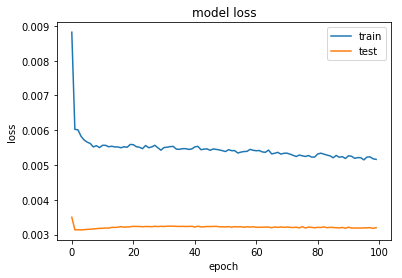

In [456]:
# Plot to show loss v.s. epoch and determine optimal epoch.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [457]:
# Have real yhat and real ytest ready for comparison.

yhat = model.predict(xtest)
yhat_inverse = scaler_absret.inverse_transform(yhat.reshape(-1, 1))
ytest_inverse = scaler_absret.inverse_transform(ytest.reshape(-1, 1))

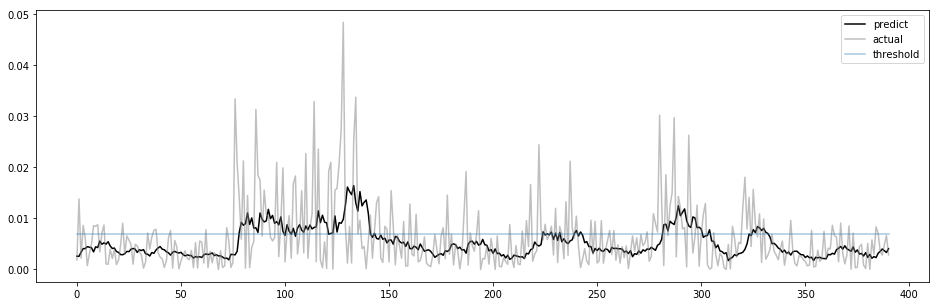

In [458]:
# Set threshold to be 0.7% and generate a plot of predicted volatility v.s. actual volatility and threshold.
threshold = np.zeros(len(yhat_inverse))
threshold = threshold+0.007

plt.subplots(figsize=(16,5))
plt.plot(yhat_inverse, label='predict', c='black')
plt.plot(ytest_inverse, label='actual', c='grey', alpha=0.5)
plt.plot(threshold, label='threshold', alpha=0.4)
plt.legend()
plt.show()

In [459]:
# Set threshold to be 0.7% and put prediction/real values in the same table.
testtable = pd.DataFrame(np.hstack((ytest_inverse[:], yhat_inverse[:])))
# testtable = pd.DataFrame({'true':ytest_inverse[:], 'hat': yhat_inverse[:]})
testtable.columns = ['true', 'hat']
testtable['true07'] = testtable['true']<0.007
testtable['hat07'] = testtable['hat']<0.007
print(testtable.head())

# Generate the confusion matrix.
from sklearn.metrics import confusion_matrix
print(sklearn.metrics.confusion_matrix(testtable.true07.values, testtable.hat07.values))

# Generate accuracy score.
from sklearn.metrics import accuracy_score
print(accuracy_score(testtable.true07.values, testtable.hat07.values))

# Generate roc_auc_score.
from sklearn.metrics import roc_auc_score
print(sklearn.metrics.roc_auc_score(testtable.true07.values, testtable.hat07.values))

       true       hat  true07  hat07
0  0.001860  0.002601    True   True
1  0.013820  0.002573   False   True
2  0.002202  0.003376    True   True
3  0.008642  0.004079   False   True
4  0.006160  0.004102    True   True
[[ 53  71]
 [ 44 223]]
0.7058823529411765
0.6313126736740364


# 2. Second Model.

In [460]:
# absret07 prediction using 14-day lags. (Binary classification using lags)
x,y=create_dataset0(v_absret07, look_back=14)

# Split by train/test split defined above. Length - 14 b/c look_back period will start y from 15th.
xtrain, xtest = x[:ltrain-14], x[ltrain-14:]
ytrain, ytest = y[:ltrain-14], y[ltrain-14:]

3252


In [461]:
# LSTM Feature engineering.
xtrain = np.reshape(xtrain, (xtrain.shape[0], 1, xtrain.shape[1]))
xtest = np.reshape(xtest, (xtest.shape[0], 1, xtest.shape[1]))

In [462]:
# LSTM Modelling.
model = Sequential()
model.add(LSTM(100, input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
# loss function is mean_squared_error.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(xtrain, ytrain, epochs= 100, batch_size=100, validation_data=(xtest, ytest), verbose=2, shuffle=False)

Train on 2861 samples, validate on 391 samples
Epoch 1/100
 - 1s - loss: 0.8070 - accuracy: 0.6215 - val_loss: 0.6250 - val_accuracy: 0.6701
Epoch 2/100
 - 0s - loss: 0.6339 - accuracy: 0.6641 - val_loss: 0.6122 - val_accuracy: 0.6829
Epoch 3/100
 - 0s - loss: 0.6175 - accuracy: 0.6690 - val_loss: 0.6088 - val_accuracy: 0.6650
Epoch 4/100
 - 0s - loss: 0.6162 - accuracy: 0.6672 - val_loss: 0.6051 - val_accuracy: 0.6777
Epoch 5/100
 - 0s - loss: 0.6158 - accuracy: 0.6690 - val_loss: 0.6034 - val_accuracy: 0.6752
Epoch 6/100
 - 0s - loss: 0.6142 - accuracy: 0.6725 - val_loss: 0.6020 - val_accuracy: 0.6726
Epoch 7/100
 - 0s - loss: 0.6114 - accuracy: 0.6746 - val_loss: 0.6011 - val_accuracy: 0.6726
Epoch 8/100
 - 0s - loss: 0.6127 - accuracy: 0.6714 - val_loss: 0.6005 - val_accuracy: 0.6701
Epoch 9/100
 - 0s - loss: 0.6120 - accuracy: 0.6704 - val_loss: 0.5995 - val_accuracy: 0.6777
Epoch 10/100
 - 0s - loss: 0.6119 - accuracy: 0.6672 - val_loss: 0.5990 - val_accuracy: 0.6752
Epoch 11/100

Epoch 87/100
 - 0s - loss: 0.5986 - accuracy: 0.6784 - val_loss: 0.6060 - val_accuracy: 0.7033
Epoch 88/100
 - 0s - loss: 0.5948 - accuracy: 0.6854 - val_loss: 0.6070 - val_accuracy: 0.7008
Epoch 89/100
 - 0s - loss: 0.5951 - accuracy: 0.6826 - val_loss: 0.6072 - val_accuracy: 0.6982
Epoch 90/100
 - 0s - loss: 0.5962 - accuracy: 0.6865 - val_loss: 0.6075 - val_accuracy: 0.6957
Epoch 91/100
 - 0s - loss: 0.5981 - accuracy: 0.6826 - val_loss: 0.6100 - val_accuracy: 0.6931
Epoch 92/100
 - 0s - loss: 0.5987 - accuracy: 0.6784 - val_loss: 0.6074 - val_accuracy: 0.6880
Epoch 93/100
 - 0s - loss: 0.5987 - accuracy: 0.6777 - val_loss: 0.6086 - val_accuracy: 0.6957
Epoch 94/100
 - 0s - loss: 0.5964 - accuracy: 0.6816 - val_loss: 0.6089 - val_accuracy: 0.6957
Epoch 95/100
 - 0s - loss: 0.5956 - accuracy: 0.6809 - val_loss: 0.6095 - val_accuracy: 0.6957
Epoch 96/100
 - 0s - loss: 0.5966 - accuracy: 0.6854 - val_loss: 0.6097 - val_accuracy: 0.6957
Epoch 97/100
 - 0s - loss: 0.5940 - accuracy: 0.67

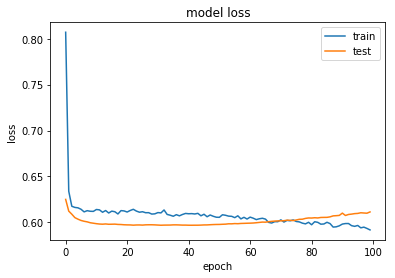

In [463]:
# Plot to show loss v.s. epoch and determine optimal epoch.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [464]:
# Print classification accuracy.
scores = model.evaluate(xtest, ytest, verbose=2)
print("Accuracy: %.2f%%" % (scores[1]*100))

# Accuracy similar to that of absolute value prediction.

Accuracy: 69.05%


# 3. Third Model.

In [467]:
# Create a dataframe to use 1-lag rollstd, voldiff, absret as input variables.
d = absret[1:]
a = absret[:-1]
b = rollstd[:-1]
c = voldiff[:-1]

df_inputs=pd.DataFrame({'a':a, 'b':b, 'c':c, 'd':d}) 
df_inputs = df_inputs.values

In [469]:
scaler = StandardScaler().fit(df_inputs)
df_inputs = scaler.transform(df_inputs)

xtrain, xtest = df_inputs[0:ltrain-1,:-1], df_inputs[ltrain-1:,:-1]
ytrain, ytest = df_inputs[0:ltrain-1, -1], df_inputs[ltrain-1:, -1]

In [470]:
xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))

In [471]:
# LSTM Modelling.
model = Sequential()
model.add(LSTM(100, input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
# loss function is mean_squared_error.
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(xtrain, ytrain, epochs= 100, batch_size=100, validation_data=(xtest, ytest), verbose=2, shuffle=False)

Train on 2874 samples, validate on 391 samples
Epoch 1/100
 - 1s - loss: 1.0281 - val_loss: 0.4880
Epoch 2/100
 - 0s - loss: 0.9768 - val_loss: 0.4713
Epoch 3/100
 - 0s - loss: 0.9326 - val_loss: 0.4575
Epoch 4/100
 - 0s - loss: 0.8935 - val_loss: 0.4471
Epoch 5/100
 - 0s - loss: 0.8610 - val_loss: 0.4396
Epoch 6/100
 - 0s - loss: 0.8370 - val_loss: 0.4350
Epoch 7/100
 - 0s - loss: 0.8157 - val_loss: 0.4324
Epoch 8/100
 - 0s - loss: 0.8048 - val_loss: 0.4312
Epoch 9/100
 - 0s - loss: 0.7930 - val_loss: 0.4310
Epoch 10/100
 - 0s - loss: 0.7855 - val_loss: 0.4309
Epoch 11/100
 - 0s - loss: 0.7752 - val_loss: 0.4316
Epoch 12/100
 - 0s - loss: 0.7713 - val_loss: 0.4330
Epoch 13/100
 - 0s - loss: 0.7670 - val_loss: 0.4339
Epoch 14/100
 - 0s - loss: 0.7643 - val_loss: 0.4353
Epoch 15/100
 - 0s - loss: 0.7624 - val_loss: 0.4366
Epoch 16/100
 - 0s - loss: 0.7640 - val_loss: 0.4379
Epoch 17/100
 - 0s - loss: 0.7597 - val_loss: 0.4389
Epoch 18/100
 - 0s - loss: 0.7616 - val_loss: 0.4396
Epoch 19

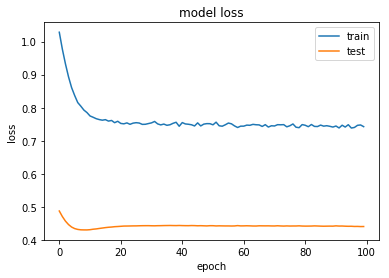

In [472]:
# Plot to show loss v.s. epoch and determine optimal epoch.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [473]:
# Have real yhat and real ytest ready for comparison.

# make a prediction
yhat = model.predict(xtest)
xtest = xtest.reshape((xtest.shape[0], xtest.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((xtest,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
yhat_inverse = inv_yhat[:,-1]

# invert scaling for actual
ytest = ytest.reshape((len(ytest), 1))
inv_y = np.concatenate((xtest, ytest), axis=1)
inv_y = scaler.inverse_transform(inv_y)
ytest_inverse = inv_y[:,-1]

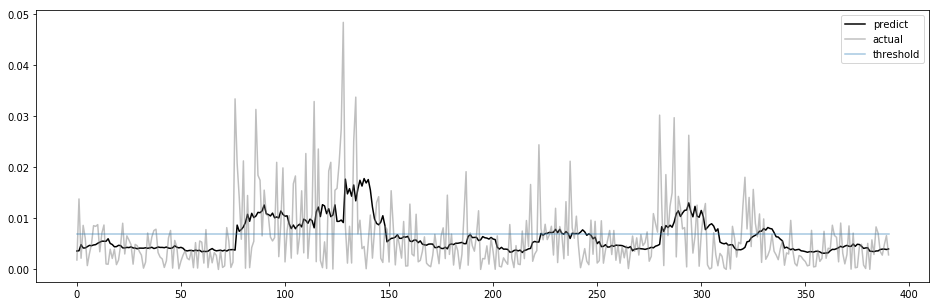

In [474]:
# Set threshold to be 0.7% and generate a plot of predicted volatility v.s. actual volatility and threshold.
threshold = np.zeros(len(yhat_inverse))
threshold = threshold+0.007

plt.subplots(figsize=(16,5))
plt.plot(yhat_inverse, label='predict', c='black')
plt.plot(ytest_inverse, label='actual', c='grey', alpha=0.5)
plt.plot(threshold, label='threshold', alpha=0.4)
plt.legend()
plt.show()

In [475]:
# Set threshold to be 0.7% and put prediction/real values in the same table.
testtable = pd.DataFrame({'true':ytest_inverse[:], 'hat': yhat_inverse[:]})
testtable.columns = ['true', 'hat']
testtable['true07'] = testtable['true']<0.007
testtable['hat07'] = testtable['hat']<0.007
print(testtable.head())

# Generate the confusion matrix.
from sklearn.metrics import confusion_matrix
print(sklearn.metrics.confusion_matrix(testtable.true07.values, testtable.hat07.values))

# Generate accuracy score.
from sklearn.metrics import accuracy_score
print(accuracy_score(testtable.true07.values, testtable.hat07.values))

# Generate roc_auc_score.
from sklearn.metrics import roc_auc_score
print(sklearn.metrics.roc_auc_score(testtable.true07.values, testtable.hat07.values))

       true       hat  true07  hat07
0  0.001860  0.003618    True   True
1  0.013820  0.003670   False   True
2  0.002202  0.004863    True   True
3  0.008642  0.004203   False   True
4  0.006160  0.004216    True   True
[[ 65  59]
 [ 61 206]]
0.6930946291560103
0.6478645644557207


# 4. Fourth Model.

In [476]:
# With one extra feature: difference between rolling 14 day std and absret.
e = absret[1:]
a = absret[:-1]
b = rollstd[:-1]
c = voldiff[:-1]
d = a-b

df_inputs=pd.DataFrame({'a':a, 'b':b, 'c':c, 'd':d, 'e':e}) 
df_inputs = df_inputs.values

scaler = StandardScaler().fit(df_inputs)
df_inputs = scaler.transform(df_inputs)

xtrain, xtest = df_inputs[0:ltrain-1,:-1], df_inputs[ltrain-1:,:-1]
ytrain, ytest = df_inputs[0:ltrain-1, -1], df_inputs[ltrain-1:, -1]

xtrain = xtrain.reshape((xtrain.shape[0], 1, xtrain.shape[1]))
xtest = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))

# LSTM Modelling.
model = Sequential()
model.add(LSTM(100, input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
# loss function is mean_squared_error.
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(xtrain, ytrain, epochs= 100, batch_size=100, validation_data=(xtest, ytest), verbose=2, shuffle=False)

# Have real yhat and real ytest ready for comparison.

# make a prediction
yhat = model.predict(xtest)
xtest = xtest.reshape((xtest.shape[0], xtest.shape[2]))

# invert scaling for forecast
inv_yhat = np.concatenate((xtest,yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
yhat_inverse = inv_yhat[:,-1]

# invert scaling for actual
ytest = ytest.reshape((len(ytest), 1))
inv_y = np.concatenate((xtest, ytest), axis=1)
inv_y = scaler.inverse_transform(inv_y)
ytest_inverse = inv_y[:,-1]

# Set threshold to be 0.7% and put prediction/real values in the same table.
testtable = pd.DataFrame({'true':ytest_inverse[:], 'hat': yhat_inverse[:]})
testtable.columns = ['true', 'hat']
testtable['true07'] = testtable['true']<0.007
testtable['hat07'] = testtable['hat']<0.007
print(testtable.head())

# Generate the confusion matrix.
from sklearn.metrics import confusion_matrix
print(sklearn.metrics.confusion_matrix(testtable.true07.values, testtable.hat07.values))

# Generate accuracy score.
from sklearn.metrics import accuracy_score
print(accuracy_score(testtable.true07.values, testtable.hat07.values))

# Generate roc_auc_score.
from sklearn.metrics import roc_auc_score
print(sklearn.metrics.roc_auc_score(testtable.true07.values, testtable.hat07.values))

Train on 2874 samples, validate on 391 samples
Epoch 1/100
 - 1s - loss: 1.0375 - val_loss: 0.4803
Epoch 2/100
 - 0s - loss: 0.9725 - val_loss: 0.4638
Epoch 3/100
 - 0s - loss: 0.9162 - val_loss: 0.4506
Epoch 4/100
 - 0s - loss: 0.8675 - val_loss: 0.4413
Epoch 5/100
 - 0s - loss: 0.8274 - val_loss: 0.4361
Epoch 6/100
 - 0s - loss: 0.7968 - val_loss: 0.4347
Epoch 7/100
 - 0s - loss: 0.7759 - val_loss: 0.4359
Epoch 8/100
 - 0s - loss: 0.7598 - val_loss: 0.4385
Epoch 9/100
 - 0s - loss: 0.7617 - val_loss: 0.4414
Epoch 10/100
 - 0s - loss: 0.7551 - val_loss: 0.4428
Epoch 11/100
 - 0s - loss: 0.7574 - val_loss: 0.4439
Epoch 12/100
 - 0s - loss: 0.7534 - val_loss: 0.4446
Epoch 13/100
 - 0s - loss: 0.7538 - val_loss: 0.4450
Epoch 14/100
 - 0s - loss: 0.7562 - val_loss: 0.4449
Epoch 15/100
 - 0s - loss: 0.7560 - val_loss: 0.4445
Epoch 16/100
 - 0s - loss: 0.7534 - val_loss: 0.4448
Epoch 17/100
 - 0s - loss: 0.7510 - val_loss: 0.4446
Epoch 18/100
 - 0s - loss: 0.7500 - val_loss: 0.4446
Epoch 19

# 5. Fifth Model.

3259
3259
3259
3259
Train on 2868 samples, validate on 391 samples
Epoch 1/100
 - 1s - loss: 0.0079 - val_loss: 0.0033
Epoch 2/100
 - 0s - loss: 0.0066 - val_loss: 0.0032
Epoch 3/100
 - 0s - loss: 0.0062 - val_loss: 0.0032
Epoch 4/100
 - 0s - loss: 0.0060 - val_loss: 0.0032
Epoch 5/100
 - 0s - loss: 0.0059 - val_loss: 0.0032
Epoch 6/100
 - 0s - loss: 0.0058 - val_loss: 0.0032
Epoch 7/100
 - 0s - loss: 0.0059 - val_loss: 0.0032
Epoch 8/100
 - 0s - loss: 0.0057 - val_loss: 0.0032
Epoch 9/100
 - 0s - loss: 0.0056 - val_loss: 0.0032
Epoch 10/100
 - 0s - loss: 0.0057 - val_loss: 0.0032
Epoch 11/100
 - 0s - loss: 0.0057 - val_loss: 0.0032
Epoch 12/100
 - 0s - loss: 0.0056 - val_loss: 0.0032
Epoch 13/100
 - 0s - loss: 0.0056 - val_loss: 0.0032
Epoch 14/100
 - 0s - loss: 0.0057 - val_loss: 0.0032
Epoch 15/100
 - 0s - loss: 0.0056 - val_loss: 0.0032
Epoch 16/100
 - 0s - loss: 0.0055 - val_loss: 0.0032
Epoch 17/100
 - 0s - loss: 0.0056 - val_loss: 0.0032
Epoch 18/100
 - 0s - loss: 0.0056 - val_l

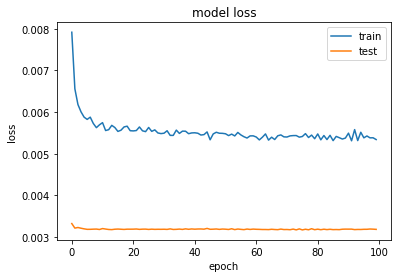

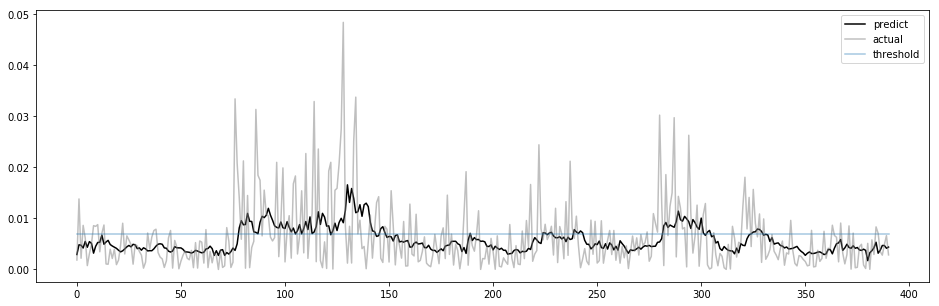

       true       hat  true07  hat07
0  0.001860  0.002934    True   True
1  0.013820  0.004843   False   True
2  0.002202  0.004750    True   True
3  0.008642  0.004208   False   True
4  0.006160  0.005491    True   True
[[ 53  71]
 [ 50 217]]
0.690537084398977
0.6200767186178566


In [477]:
# absret prediction using 7-day lags of rollstd, voldiff, rolldiff.
x1,y1=create_dataset0(v_absret, look_back=7)
x2, y2 = create_dataset1(v_rollstd, v_absret, look_back=7)
x3, y3 = create_dataset1(v_voldiff, v_absret, look_back=7)
x4, y4 = create_dataset1(v_rolldiff, v_absret, look_back=7)
x = np.concatenate((x1, x2, x3, x4), 1)
y = y1

xtrain, xtest = x[:ltrain-7], x[ltrain-7:]
ytrain, ytest = y[:ltrain-7], y[ltrain-7:]

# LSTM Feature engineering.
xtrain = np.reshape(xtrain, (xtrain.shape[0], 1, xtrain.shape[1]))
xtest = np.reshape(xtest, (xtest.shape[0], 1, xtest.shape[1]))

# LSTM Modelling.
model = Sequential()
model.add(LSTM(100, input_shape=(xtrain.shape[1], xtrain.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
# loss function is mean_squared_error.
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(xtrain, ytrain, epochs= 100, batch_size=100, validation_data=(xtest, ytest), verbose=2, shuffle=False)

# Plot to show loss v.s. epoch and determine optimal epoch.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# Have real yhat and real ytest ready for comparison.

yhat = model.predict(xtest)
yhat_inverse = scaler_absret.inverse_transform(yhat.reshape(-1, 1))
ytest_inverse = scaler_absret.inverse_transform(ytest.reshape(-1, 1))

# Set threshold to be 0.7% and generate a plot of predicted volatility v.s. actual volatility and threshold.
threshold = np.zeros(len(yhat_inverse))
threshold = threshold+0.007

plt.subplots(figsize=(16,5))
plt.plot(yhat_inverse, label='predict', c='black')
plt.plot(ytest_inverse, label='actual', c='grey', alpha=0.5)
plt.plot(threshold, label='threshold', alpha=0.4)
plt.legend()
plt.show()

# Set threshold to be 0.7% and put prediction/real values in the same table.
testtable = pd.DataFrame(np.hstack((ytest_inverse[:], yhat_inverse[:])))

#testtable = pd.DataFrame({'true':ytest_inverse[:], 'hat': yhat_inverse[:]})
testtable.columns = ['true', 'hat']
testtable['true07'] = testtable['true']<0.007
testtable['hat07'] = testtable['hat']<0.007
print(testtable.head())

# Generate the confusion matrix.
from sklearn.metrics import confusion_matrix
print(sklearn.metrics.confusion_matrix(testtable.true07.values, testtable.hat07.values))

# Generate accuracy score.
from sklearn.metrics import accuracy_score
print(accuracy_score(testtable.true07.values, testtable.hat07.values))

# Generate roc_auc_score.
from sklearn.metrics import roc_auc_score
print(sklearn.metrics.roc_auc_score(testtable.true07.values, testtable.hat07.values))

# 6. Sith model.

In [542]:
# absret prediction using 28-day lags of rollstd, voldiff, rolldiff.
x1,y1=create_dataset0(v_absret, look_back=28)
x2, y2 = create_dataset1(v_rollstd, v_absret, look_back=28)
x3, y3 = create_dataset1(v_voldiff, v_absret, look_back=28)
x4, y4 = create_dataset1(v_rolldiff, v_absret, look_back=28)
x = np.concatenate((x1, x2, x3, x4), 1)
y = y1

xtrain, xtest = x[:ltrain-28], x[ltrain-28:]
ytrain, ytest = y[:ltrain-28], y[ltrain-28:]

# LSTM Feature engineering.
xtrain = np.reshape(xtrain, (xtrain.shape[0], 1, xtrain.shape[1]))
xtest = np.reshape(xtest, (xtest.shape[0], 1, xtest.shape[1]))



3238
3238
3238
3238


In [543]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.models import Sequential
import time

In [544]:
# Try different modelling ways.

dropout_rate = 0.45

model = Sequential()

model.add(LSTM(units=16, return_sequences=True))
model.add(Dropout(rate=dropout_rate))
model.add(LSTM(units=8, return_sequences=False))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(units=8))
model.add(Activation("relu"))
model.add(Dropout(rate=dropout_rate))
model.add(Dense(units=1))
model.add(Activation("linear"))
rms=optimizers.RMSprop(lr=2e-3, rho=0.9, epsilon=1e-06)

start = time.time()
model.compile(loss="mse", optimizer=rms)
print ('compilation time : ', time.time() - start)

model.fit(x=xtrain, y=(ytrain), epochs=100, batch_size=30)

yhat = model.predict(xtest)
yhat_inverse = scaler_absret.inverse_transform(yhat.reshape(-1, 1))
ytest_inverse = scaler_absret.inverse_transform(ytest.reshape(-1, 1))

# Set threshold to be 0.7% and generate a plot of predicted volatility v.s. actual volatility and threshold.
threshold = np.zeros(len(yhat_inverse))
threshold = threshold+0.007

plt.subplots(figsize=(16,5))
plt.plot(yhat_inverse, label='predict', c='black')
plt.plot(ytest_inverse, label='actual', c='grey', alpha=0.5)
plt.plot(threshold, label='threshold', alpha=0.4)
plt.legend()
plt.show()

# Set threshold to be 0.7% and put prediction/real values in the same table.
testtable = pd.DataFrame(np.hstack((ytest_inverse[:], yhat_inverse[:])))

#testtable = pd.DataFrame({'true':ytest_inverse[:], 'hat': yhat_inverse[:]})
testtable.columns = ['true', 'hat']
testtable['true07'] = testtable['true']<0.007
testtable['hat07'] = testtable['hat']<0.007
print(testtable.head())

# Generate the confusion matrix.
from sklearn.metrics import confusion_matrix
print(sklearn.metrics.confusion_matrix(testtable.true07.values, testtable.hat07.values))

# Generate accuracy score.
from sklearn.metrics import accuracy_score
print(accuracy_score(testtable.true07.values, testtable.hat07.values))

# Generate roc_auc_score.
from sklearn.metrics import roc_auc_score
print(sklearn.metrics.roc_auc_score(testtable.true07.values, testtable.hat07.values))

compilation time :  0.00046372413635253906
